In [1]:
# Imports
import pathlib
from transformations import (
    ComposeDouble,
    normalize_01,
    AlbuSeg2d,
    FunctionWrapperDouble,
    create_dense_target,
)
from sklearn.model_selection import train_test_split
from customdatasets import TrackDataset
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations as A


In [5]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import FloatProgress

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# pre-transformations
pre_transforms = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(64, 64, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(64, 64),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
    ]
)

# training transformations and augmentations
transforms_training = ComposeDouble(
    [                
        AlbuSeg2d(A.RandomBrightnessContrast(p=0.5)),
        AlbuSeg2d(A.HorizontalFlip(p=0.5)),
        AlbuSeg2d(A.ChannelShuffle(p=0.2)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(64, 64, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(64, 64),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
# random_seed = 42

# # split dataset into training set and validation set
# train_size = 0.8  # 80:20 split


# root directory
train_root = pathlib.Path.cwd() / "dataset_large/train"
val_root = pathlib.Path.cwd() / "dataset_large/val"
# input and target files
inputs_train = get_filenames_of_path(train_root / "images")
targets_train = get_filenames_of_path(train_root / "targets")

inputs_valid = get_filenames_of_path(val_root / "images")
targets_valid = get_filenames_of_path(val_root / "targets")
# inputs_train, inputs_valid = train_test_split(
#     inputs, random_state=random_seed, train_size=train_size, shuffle=True
# )

# targets_train, targets_valid = train_test_split(
#     targets, random_state=random_seed, train_size=train_size, shuffle=True
# )

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = TrackDataset(
    inputs=inputs_train,
    targets=targets_train,
    transform=transforms_training,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataset validation
dataset_valid = TrackDataset(
    inputs=inputs_valid,
    targets=targets_valid,
    transform=transforms_validation,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=1, shuffle=True)

Caching:   0%|          | 0/2584 [00:00<?, ?it/s]

Caching:   0%|          | 0/134 [00:00<?, ?it/s]

In [13]:
import torch.nn as nn
#dice loss function
# class DiceLoss(torch.nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()
#         self.smooth = 1.0

#     def forward(self, y_pred, y_true):
#         print(y_pred.size())
#         print(y_true.size())
#         assert y_pred.size() == y_true.size()
#         y_pred = y_pred[:, 0].contiguous().view(-1)
#         y_true = y_true[:, 0].contiguous().view(-1)
#         intersection = (y_pred * y_true).sum()
#         dsc = (2.*intersection+ elf.smooth)/(y_pred.sum()+y_true.sum()+self.smooth)
#         return 1. - dsc

class MulticlassDiceLoss(nn.Module):
    """Reference: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
    """
    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim
    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        """The "reduction" argument is ignored. This method computes the dice
        loss for all classes and provides an overall weighted loss.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)
        # end if
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)
        
        # Convert from NHWC to NCHW
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)
        # print(targets_one_hot.shape)
        # Multiply one-hot encoded ground truth labels with the probabilities to get the
        # prredicted probability for the actual class.
        intersection = (targets_one_hot * probabilities).sum()
        
        mod_a = intersection.sum()
        mod_b = targets.numel()
        
        dice_coefficient = 2. * intersection / (mod_a + mod_b + smooth)
        dice_loss = -dice_coefficient.log()
        # dice_loss = 1 - dice_coefficient
        return dice_loss


# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
# out-channels is the number of segementation classes
model = UNet(
    in_channels=3,
    out_channels=4,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
# criterion = torch.nn.CrossEntropyLoss()
# criterion = DiceLoss()
criterion = MulticlassDiceLoss(num_classes=4, softmax_dim=1)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=15, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=scheduler,
    epochs=400,
    epoch=0,
    notebook=True,
    checkpoint_dir=f"experiment_lr_on_plateau_dataset_large_color_aug",
    save_frequency=1
)

In [ ]:
training_losses, validation_losses, lr_rates, data = trainer.run_trainer()


[0.020623341634515117, 0.022023330460851594, 0.022918316923123575, 0.0356794328732006, 0.022073483558496768, 0.02148079281453905, 0.07659207520582505, 0.021690133612415296, 0.025450550978864308, 0.03247466804668196, 0.04358271962820566, 0.02394139778769033, 0.022118945746793787, 0.014511550344881226, 0.023619707070860956, 0.021159860434934997, 0.007864475261538164, 0.018758006484261645, 0.022020824005524974, 0.01130470928367672, 0.005293538608873235, 0.027553584689879094, 0.006445773051002188, 0.004537279317989501, 0.005087603743660694, 0.009207521397585688, 0.006461673873170877, 0.009663721361482488, 0.00835739639448697, 0.004569020857269973, 0.004081665494812847, 0.004146811787348324, 0.007732894672984396, 0.007242468919834372, 0.004970260544805162, 0.006187941617533953, 0.004013744592075862, 0.004893936989603063, 0.004747634664970214, 0.011673919731445277, 0.006196487170240995, 0.003744715919419289, 0.004623427449329409, 0.006981074277471418, 0.007921606667145198, 0.0037000771392998

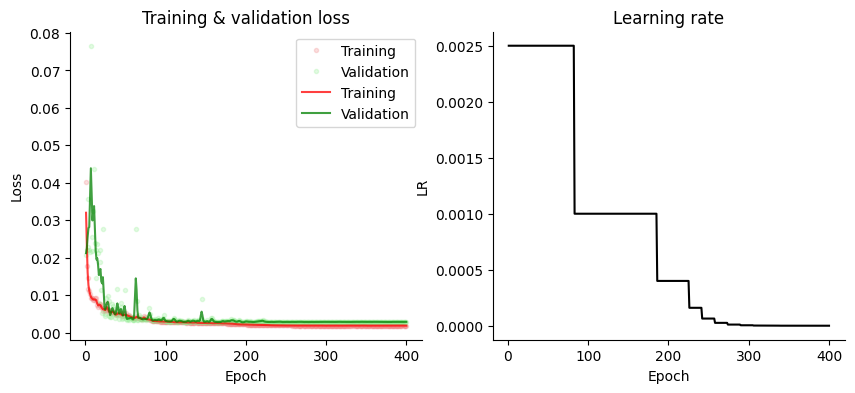

In [15]:
from visual import plot_training

fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)
print(validation_losses)
print(training_losses)
print(f"best weights at epoch {np.argmin(validation_losses)+1} having loss {np.min(validation_losses)}")

In [16]:
for i in range(len(validation_losses)):
    print(i, validation_losses[i])

0 0.020623341634515117
1 0.022023330460851594
2 0.022918316923123575
3 0.0356794328732006
4 0.022073483558496768
5 0.02148079281453905
6 0.07659207520582505
7 0.021690133612415296
8 0.025450550978864308
9 0.03247466804668196
10 0.04358271962820566
11 0.02394139778769033
12 0.022118945746793787
13 0.014511550344881226
14 0.023619707070860956
15 0.021159860434934997
16 0.007864475261538164
17 0.018758006484261645
18 0.022020824005524974
19 0.01130470928367672
20 0.005293538608873235
21 0.027553584689879094
22 0.006445773051002188
23 0.004537279317989501
24 0.005087603743660694
25 0.009207521397585688
26 0.006461673873170877
27 0.009663721361482488
28 0.00835739639448697
29 0.004569020857269973
30 0.004081665494812847
31 0.004146811787348324
32 0.007732894672984396
33 0.007242468919834372
34 0.004970260544805162
35 0.006187941617533953
36 0.004013744592075862
37 0.004893936989603063
38 0.004747634664970214
39 0.011673919731445277
40 0.006196487170240995
41 0.003744715919419289
42 0.004623